In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

RNNやLSTMを使った楽しいアプリケーション
- コーパスを使って学習した言語モデルを使った文章生成とその改良  
- seq2seq(sequence to sequence)
    - 2つのRNNを組み合わせて実装する
    - 機械翻訳やチャットボット，メールの自動返信などに使える

## まとめ
- 文章生成
    - RNNの入力に任意の単語を入れ，次の単語を予測していく．
    - 単語を出力される確率分布に従ってランダムにサンプルすることで，多様な文章が作成される
    - RNNの性能が良くなれば出力される文章もより自然になる．
    - 「the meaning of life is」のように複数の単語を最初に入力してやるのも面白い．
- Seq2seq(Encoder-Decoderモデル)
    - EncoderとDecoderという2つのRNNを使ってある時系列データを別の時系列データに変換する
    - EncoderのRNNの最後の時刻から出力される隠れ状態は入力データを圧縮したデータになる．
    - 入力データを反転させることで精度が上がることがある
    - 隠れ状態をDecoderのRNN以外の層にも渡してやることで精度が上がることがある
    - 足し算を文字のみから解かせる問題を上記の方法で学習させると，正答率が90%を超える
    - 応用分野が広く，実践的な技術
        - 機械翻訳
        - 自動要約
        - 質疑応答
        - メール自動返信
        - チャットボットによる問題解決
        - アルゴリズムの学習，自動プログラミング
        - イメージキャプション

# 言語モデルを使った文章生成

## RNNによる文章生成の手順
例えば，
<div style="text-align: center">you say goodbye and I say Hello . </div>  

というコーパスで学習を行った言語モデルでは，「I」を入力すると次に出現する単語は「say」の確率が高くなる．  
このことを利用して文章生成ができる．  
<br>
もっとも確率の高い単語を選び続ければ結果は一意に定まってしまう．(決定的なアルゴリズム)  
しかし，確率的に単語を選べば毎回異なった文章が生成できる．  
この作業を望む回数だけ，または<eos\>のような文末記号が出現するまで繰り返す．  
このようにしてできた文章は，訓練データには存在しない文章の並びになりうる．  

## 文章生成の実装
前章で実装したRnnlmクラスをベースに，それを継承してRnnlmGenクラスを生成する.  
このクラスに文章生成を行うメソッドを追加する．

In [2]:
from common.functions import softmax
from ch06.rnnlm import Rnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        """
        言語モデルから文章の生成を行う．
        
        Parameters
        --------------
        start_id: int
            文章生成の際の最初の単語のID
        skip_ids: Array<int>
            文章生成の際サンプリングしたくない単語のID
            PTBデータセットの<unk>(レアな単語)やN(数値)などの前処理されたデータをサンプリングしないようにする用途で使う
        sample_size: int = 100
            生成する文章の長さ
        """
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # 文章の長さ1,バッチサイズも1の入力データに変換
            score = self.predict(x) # 次の単語を予測
            p = softmax(score.flatten()) # 予測結果の確率分布を取得(softmaxで正規化)
            
            sampled = np.random.choice(len(p), size=1, p=p) # 予測結果の確率分布を使ってp個の単語の中から次の単語1個をサンプル
            
            if (skip_ids is None) or (sampled not in skip_ids): # skip_idが空ならSkip_IDの探索を行わない
                x = sampled # Skipワードでなければこの単語を次の探索に使う
                word_ids.append(int(x))
        
        return word_ids # 生成された文章

まずは重みパラメータがランダムな初期値の状態で文章作成を行わせてみる．

In [3]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./ch06/Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you must relevant them or ever.
 they are going to put up up however up or do few more people who still seek wedd.
 so far as the end sentencing into unsolicited particular types of commodity power intend to cut out of a dollar 's low percentage of gross rates on the crop ended oct. and has others cheaper as it seen during the row of insurance rates and less than most of the products can get them evident.
 lawrence red people would have seen themselves out of each other than the california triple.
 mr. roman


初期値で文章を生成した結果の一例  
<br>
you heating destroying split yale proteins teacher flowing shoulder collection knowledgeable whitten pence cancer balance buildings geared profession growing tonight hud compounded franchisers still cooperative reitman settlement benjamin bail lenses johns sometimes processing quickly arab wins edge men asia louis rate statute short destruction founded contrast potato robust steadily net either shapiro contest begins participate buffer accounted cautiously travel embraced refunding merchandising passenger referring issuer shaking ring vintage largest john passion resign urged them poland sandinistas anderson native dominates tire bruce justified istat des dean westridge perceptions talk enough brisk handed airline foot panic sedan scores transport exodus 24-hour championship  
<br>
でたらめである．

学習済みのパラメータを使って文章を生成した結果の一例  
<br>
you get the people.
we 'll have offered sound to approach wood.
the game 's effort has shown in australia or the additional year because of which the grocery circuit plans to assist in reins the vice securities known as directors of manufacturers hanover corp. 's employee plans to be provided impact on the problem.
state the losses are bonuses at the number of expires tomorrow.
the largest u.s. operations is increasingly offset by tuesday 's goal but expensive purchases by itself morgan competitive authorities said.
roberti sciences studies typically trust to redeem steadily customers  
<br>
文法的に正しい文章もあるようだが，意味の通じない文章も散見される．

## さらに良い文章へ
Better Rnnlmを使ったらもうちょっと良い文章になるのでは？

In [4]:
from ch06.better_rnnlm import BetterRnnlm

class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        """
        言語モデルから文章の生成を行う．
        
        Parameters
        --------------
        start_id: int
            文章生成の際の最初の単語のID
        skip_ids: Array<int>
            文章生成の際サンプリングしたくない単語のID
            PTBデータセットの<unk>(レアな単語)やN(数値)などの前処理されたデータをサンプリングしないようにする用途で使う
        sample_size: int = 100
            生成する文章の長さ
        """
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # 文章の長さ1,バッチサイズも1の入力データに変換
            score = self.predict(x) # 次の単語を予測
            p = softmax(score.flatten()) # 予測結果の確率分布を取得(softmaxで正規化)
            
            sampled = np.random.choice(len(p), size=1, p=p) # 予測結果の確率分布を使ってp個の単語の中から次の単語1個をサンプル
            
            if (skip_ids is None) or (sampled not in skip_ids): # skip_idが空ならSkip_IDの探索を行わない
                x = sampled # Skipワードでなければこの単語を次の探索に使う
                word_ids.append(int(x))
        
        return word_ids # 生成された文章

In [5]:
model = BetterRnnlmGen()
"""
model.load_params('./ch06/BetterRnnlm.pkl') # 自分で作るしかない…

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)
"""

"\nmodel.load_params('./ch06/BetterRnnlm.pkl') # 自分で作るしかない…\n\n# start文字とskip文字の設定\nstart_word = 'you'\nstart_id = word_to_id[start_word]\nskip_words = ['N', '<unk>', '$']\nskip_ids = [word_to_id[w] for w in skip_words]\n\n# 文章生成\nword_ids = model.generate(start_id, skip_ids)\ntxt = ' '.join([id_to_word[i] for i in word_ids])\ntxt = txt.replace(' <eos>', '.\n')\nprint(txt)\n"

 これを実行するとなかなか自然な文が生成される．

上では最初の単語のみを与えたが，「the meaning of life is」のように複数の単語を与えることもできる．  
この結果はなんだか深いのが返ってくる

# seq2seq
ある時系列データを別の時系列データに変換する．  
例えば機械翻訳，チャットボット，コンパイラなど  
ここでは2つのRNNを利用するseq2seq(sequence to sequence)を見ていく．

## seq2seqの原理
seq2seqはEncoder-Decorderモデルとも呼ばれる．  
Encode: 情報をある規則に基づいて符号に変換すること．  A -> 1000001  
Decode: Encodeされた情報を元の情報に戻すこと. 1000001 -> A  
<br>
翻訳を行う例でseq2seqの流れを説明すると以下のようになる．  
<div style="text-align: center">「我輩は猫である」 -> Encoder -> コンパクトな情報 -> Decoder -> 「I am a cat」</div>

Encoder, DecoderにRNNを使うことができる．  
<br>
Encoderは各単語ごとにEmbeddingレイヤとLSTMレイヤ(RNNやGRUでもOK)を通し，時系列方向に連結したものである．  
最後の時刻のLSTMレイヤが出力するデータを，時系列データ$h$という隠れ状態ベクトルとして出力する．  
$h$は固定長のベクトルである．エンコードとは任意の長さのデータを固定長のベクトルに変換することである．  
<br>
Decoderは前節のRNNLMを使った文章生成モデルとほぼ同様の構成をとる.  
違うのは，最初のLSTKレイヤがEncoderから渡されたベクトル$h$を利用し，また最初の単語として<eos\>などの区切り文字を入力すること．  
文章生成モデルではLSTMレイヤは隠れ状態として何も受け取っていなかった．(零ベクトルを受け取っていた)  
LSTMにサンプリングの開始/終了を伝えるため，<go\>, <start\>, \_などが使われることもある．

余談  
敵対し合うのがGANなら協力し合うのがseq2seq?

## 時系列データ変換用のトイ・プロブレム
seq2seqの実装を評価する問題として，足し算を扱う．例えば，  
<div style="text-align: center">57+5 -> 62</div>
このような，機械学習を評価するために作られた簡単な問題はトイ・プロブレムと呼ばれる．  
今回の問題は，文を単語ではなく文字で分割し，
<div style="text-align: center">57+5 -> ['5', '7', '+', '5']</div>
のようにして扱う．  

## 可変長の時系列データ
足し算をCharacterのリストとして扱うと，問題ごとに文字数が異なってしまうことが問題になる．  
ミニバッチ学習を行うときには，複数のサンプルをまとめて処理する必要があるので，空白文字でパディングを行う．  
また，区切り文字としてアンダースコア「_」を出力の先頭につけ，Decoderに文字列生成を知らせる合図(最初の単語)とする.  
<br>
最大3桁＋3桁の計算を行う例  
<div style="text-align: center">「57+5   」 -> 「_62  」</div>

最大で4桁の数(999+999=1998)なので，出力は5文字になる．    
<br>
パディングの文字まで処理させることになってしまうので，SoftmaxWithLossレイヤにマスク機能を追加し，損失の結果に計上しないようにする．  
また，Encoderはパディングが入力された時，前時刻の入力をそのまま出力する．  
<br>
本章ではわかりやすさを優先して，パディング用の文字に対して特別な処理を行わず，通常のデータとして処理することにする．  

## 足し算データセット
50000個の足し算の例がdataset/addition.txtにあらかじめ用意されている．  
この学習データはKerasのseq2seqの実装例を参考に作成されている．  
<br>
本書ではseq2seq用の学習データ(txt)を扱う専用モジュールが提供されている．

In [6]:
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984) # 固定で10％がテストデータになる.seedはシャッフルの．
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape) # (45000, 7) (45000, 5)
print(x_test.shape, t_test.shape) # (5000, 7) (5000, 5)

print(x_train[0]) # 最初の足し算の問題(データはIDで入っている)
print(t_train[0]) # 最初の足し算の答え(データはIDで入っている)

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


# seq2seqの実装
EncoderクラスとDecoderクラスをそれぞれ実装する．

## Encoderクラス
EncoderはLSTMの隠れ状態だけをDecoderに渡す．  
記憶セルをDecoderに渡すことは可能だが，LSTM自身だけで利用する前提として設計されているため，一般的には行われていない．

In [7]:
from common.time_layers import TimeEmbedding, TimeLSTM

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        
        # 前章までの言語モデルは長い時系列データがひとつ存在するものだった(ブロック同士はつながりをもっていた)
        # ここでは短い時系列データが複数存在する問題なので，問題ごとにLSTMの隠れ状態をリセットするようstateful=Falseに設定する．
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :] # 最後の時刻のデータ，Decorderに渡す
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh # 勾配の初期値として最後の勾配をDecorderから渡ってきた勾配にする．
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## Decoderクラス
同じ順方向でも，学習のforwardと文章生成のgenerateでは挙動が違うことに注意する．  
入力データは['\_', '6', '2', ' ']を与え，対応する出力として['6', '2', ' ', ' ']を教師データとして与える．  
<br>
また，文章生成の時は確率的に出力単語を選んだが，ここではもっとも高いスコアを持つ文字を決定的に選んでいく．(計算なので）   
最大スコアを持つインデックスを選ぶノードとしてargmaxノードを登場させる．  最大のものを選べば良いので，Softmaxをする必要はない．  
損失を計算して逆伝播に流すSoftmaxWithLossはseq2seqクラスで使う．

In [8]:
from common.time_layers import TimeAffine

class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        
        # 頭のhをset -> forwardという流れで学習を行う．
        # このとき，statefulがFalseだと，forwardするときにせっかくEncoderから渡されたhをリセットしてしまうので，Trueにしておく．
        # 前章では，前時刻のLSTMブロックから次のLSTMブロックへのつながりを表現するためにstatefulをTrueにセットしていた．
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, h):
        self.lstm.set_state(h) # EncodeされたsequenceをLSTMに入力
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh # TimeLSTMのhの勾配をEncoderに流す
        return dh
    
    # 同じ順方向でも，文章生成のforwardとは違うデータの与え方をする．
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten()) # 最も確率の高い文字のIDを取得
            sampled.append(int(sample_id))
            
        return sampled

## Seq2seqクラス
EncoderクラスとDecoderクラスをつなぎ合わせ，TimeSoftmaxWithLossレイヤを使って損失を計算し，逆伝播をおこなう．

In [9]:
from common.base_model import BaseModel
from common.time_layers import TimeSoftmaxWithLoss

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## seq2seqの評価
足し算問題を解いてみる

In [10]:
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq # 足し算の正解数を数える関数
from dataset import sequence

def learnSeq2seq(x_train, t_train, x_text, t_test, char_to_id, id_to_char, seq2seq_model=Seq2seq):
    # ハイパーパラメータの設定
    vocab_size = len(char_to_id)
    wordvec_size = 16
    hidden_size = 128
    batch_size = 128
    max_epoch = 25
    max_grad = 5.0

    # モデル / オプティマイザ / トレーナーの作成
    model = seq2seq_model(vocab_size, wordvec_size, hidden_size)
    
    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        trainer.fit(x_train, t_train, max_epoch=1,batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbos = i < 10 # テストデータの最初の10個を結果表示
            correct_num += eval_seq2seq(model, question, correct, id_to_char, verbos) # 入力文を反転したかを指定するis_reverseもある

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print('val acc %.3f%%' % (acc * 100))
    
    return acc_list

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 2[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 3[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 3[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 4[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 4[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 5[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 5[s] | loss 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 66

| epoch 7 |  iter 341 / 351 | time 5[s] | loss 1.04
Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1166
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 148 
---
Q 367+55 
T 422 
X 418 
---
Q 600+257
T 857 
X 893 
---
Q 761+292
T 1053
X 1058
---
Q 830+597
T 1427
X 1444
---
Q 26+838 
T 864 
X 867 
---
Q 143+93 
T 236 
X 227 
---
val acc 3.540%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.07
| epoch 8 |  iter 21 / 351 | time 0[s] | loss 1.04
| epoch 8 |  iter 41 / 351 | time 0[s] | loss 1.04
| epoch 8 |  iter 61 / 351 | time 0[s] | loss 1.03
| epoch 8 |  iter 81 / 351 | time 1[s] | loss 1.03
| epoch 8 |  iter 101 / 351 | time 1[s] | loss 1.04
| epoch 8 |  iter 121 / 351 | time 1[s] | loss 1.05
| epoch 8 |  iter 141 / 351 | time 2[s] | loss 1.04
| epoch 8 |  iter 161 / 351 | time 2[s] | loss 1.03
| epoch 8 |  iter 181 / 351 | time 2[s] | loss 1.03
| epoch 8 |  iter 201 / 351 | time 3[s] | loss 1.04
| epoch 8 |  iter 221 / 351 | time 3[s] | loss 1.02
| epoch 8 |  iter 241 / 351 | time 

| epoch 14 |  iter 181 / 351 | time 3[s] | loss 0.89
| epoch 14 |  iter 201 / 351 | time 3[s] | loss 0.88
| epoch 14 |  iter 221 / 351 | time 3[s] | loss 0.88
| epoch 14 |  iter 241 / 351 | time 4[s] | loss 0.91
| epoch 14 |  iter 261 / 351 | time 4[s] | loss 0.88
| epoch 14 |  iter 281 / 351 | time 4[s] | loss 0.88
| epoch 14 |  iter 301 / 351 | time 4[s] | loss 0.89
| epoch 14 |  iter 321 / 351 | time 5[s] | loss 0.87
| epoch 14 |  iter 341 / 351 | time 5[s] | loss 0.88
Q 77+85  
T 162 
X 160 
---
Q 975+164
T 1139
X 1108
---
Q 582+84 
T 666 
X 659 
---
Q 8+155  
T 163 
X 171 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 855 
---
Q 761+292
T 1053
X 1059
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 239 
---
val acc 8.000%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.83
| epoch 15 |  iter 21 / 351 | time 0[s] | loss 0.92
| epoch 15 |  iter 41 / 351 | time 0[s] | loss 0.88
| epoch 15 |  iter 61 / 351 | time 1[s] | loss 0.87
| epoch 15 |  iter 81

val acc 10.540%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.79
| epoch 21 |  iter 21 / 351 | time 0[s] | loss 0.79
| epoch 21 |  iter 41 / 351 | time 0[s] | loss 0.81
| epoch 21 |  iter 61 / 351 | time 0[s] | loss 0.84
| epoch 21 |  iter 81 / 351 | time 1[s] | loss 0.83
| epoch 21 |  iter 101 / 351 | time 1[s] | loss 0.81
| epoch 21 |  iter 121 / 351 | time 1[s] | loss 0.83
| epoch 21 |  iter 141 / 351 | time 2[s] | loss 0.85
| epoch 21 |  iter 161 / 351 | time 2[s] | loss 0.83
| epoch 21 |  iter 181 / 351 | time 3[s] | loss 0.83
| epoch 21 |  iter 201 / 351 | time 3[s] | loss 0.82
| epoch 21 |  iter 221 / 351 | time 4[s] | loss 0.82
| epoch 21 |  iter 241 / 351 | time 4[s] | loss 0.82
| epoch 21 |  iter 261 / 351 | time 4[s] | loss 0.80
| epoch 21 |  iter 281 / 351 | time 5[s] | loss 0.80
| epoch 21 |  iter 301 / 351 | time 5[s] | loss 0.82
| epoch 21 |  iter 321 / 351 | time 6[s] | loss 0.81
| epoch 21 |  iter 341 / 351 | time 6[s] | loss 0.81
Q 77+85  
T 162 
O 162 
---
Q 975+16

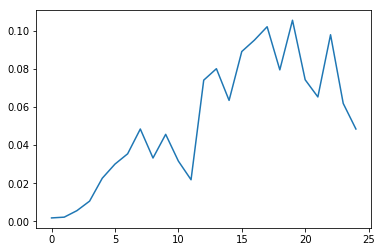

In [11]:
# データセットの読み込み
(x_train, t_train), (x_text, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

acc_list = learnSeq2seq(x_train, t_train, x_text, t_test, char_to_id, id_to_char)

plt.plot(acc_list)

だいたい10％くらいしか当たらない

# seq2seqの改良
2つの改善を実施

## 入力データの反転(Reverse)
入力データをパディング混みで反転させる．  
順方向も学習させるのではなく，反転させたものだけを学習させる

In [12]:
# 反転の練習
a = [1,2,3,4,5,6,7,8,9,10]
print(a[::-1]) # 逆転(0文字おき)
print(a[3::-1]) # 逆転させて3番目以降
print(a[:3:-1]) #逆転させて後ろの3,2,1,0番をカット

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[4, 3, 2, 1]
[10, 9, 8, 7, 6, 5]


| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 2[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 4[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 4[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 4[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 5[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 5[s] | loss 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 66

| epoch 7 |  iter 341 / 351 | time 6[s] | loss 0.62
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1142
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
X 162 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 859 
---
Q 292+167
T 1053
X 1144
---
Q 795+038
T 1427
X 1431
---
Q  838+62
T 864 
X 866 
---
Q  39+341
T 236 
X 239 
---
val acc 17.500%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.66
| epoch 8 |  iter 21 / 351 | time 0[s] | loss 0.61
| epoch 8 |  iter 41 / 351 | time 0[s] | loss 0.62
| epoch 8 |  iter 61 / 351 | time 0[s] | loss 0.61
| epoch 8 |  iter 81 / 351 | time 1[s] | loss 0.61
| epoch 8 |  iter 101 / 351 | time 1[s] | loss 0.61
| epoch 8 |  iter 121 / 351 | time 2[s] | loss 0.60
| epoch 8 |  iter 141 / 351 | time 2[s] | loss 0.60
| epoch 8 |  iter 161 / 351 | time 2[s] | loss 0.59
| epoch 8 |  iter 181 / 351 | time 3[s] | loss 0.58
| epoch 8 |  iter 201 / 351 | time 3[s] | loss 0.59
| epoch 8 |  iter 221 / 351 | time 4[s] | loss 0.60
| epoch 8 |  iter 241 / 351 | time

| epoch 14 |  iter 161 / 351 | time 2[s] | loss 0.38
| epoch 14 |  iter 181 / 351 | time 3[s] | loss 0.38
| epoch 14 |  iter 201 / 351 | time 3[s] | loss 0.38
| epoch 14 |  iter 221 / 351 | time 3[s] | loss 0.38
| epoch 14 |  iter 241 / 351 | time 4[s] | loss 0.39
| epoch 14 |  iter 261 / 351 | time 4[s] | loss 0.40
| epoch 14 |  iter 281 / 351 | time 4[s] | loss 0.41
| epoch 14 |  iter 301 / 351 | time 5[s] | loss 0.39
| epoch 14 |  iter 321 / 351 | time 5[s] | loss 0.39
| epoch 14 |  iter 341 / 351 | time 5[s] | loss 0.39
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1137
---
Q  48+285
T 666 
X 667 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1426
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 235 
---
val acc 36.680%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.38
| epoch 15 |  iter 21 / 351 | time 0[s] | loss 0.39
| epoch 15 |  iter 41 / 351 | time 0[s] | loss 0.39
| epoch 15 |  iter 

Q  39+341
T 236 
O 236 
---
val acc 50.140%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.31
| epoch 21 |  iter 21 / 351 | time 0[s] | loss 0.31
| epoch 21 |  iter 41 / 351 | time 0[s] | loss 0.30
| epoch 21 |  iter 61 / 351 | time 1[s] | loss 0.30
| epoch 21 |  iter 81 / 351 | time 1[s] | loss 0.32
| epoch 21 |  iter 101 / 351 | time 2[s] | loss 0.32
| epoch 21 |  iter 121 / 351 | time 2[s] | loss 0.31
| epoch 21 |  iter 141 / 351 | time 2[s] | loss 0.30
| epoch 21 |  iter 161 / 351 | time 3[s] | loss 0.31
| epoch 21 |  iter 181 / 351 | time 3[s] | loss 0.31
| epoch 21 |  iter 201 / 351 | time 3[s] | loss 0.31
| epoch 21 |  iter 221 / 351 | time 3[s] | loss 0.32
| epoch 21 |  iter 241 / 351 | time 4[s] | loss 0.31
| epoch 21 |  iter 261 / 351 | time 4[s] | loss 0.29
| epoch 21 |  iter 281 / 351 | time 4[s] | loss 0.30
| epoch 21 |  iter 301 / 351 | time 5[s] | loss 0.29
| epoch 21 |  iter 321 / 351 | time 5[s] | loss 0.29
| epoch 21 |  iter 341 / 351 | time 5[s] | loss 0.29
Q   58+7

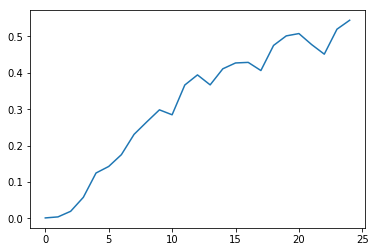

In [13]:
(x_train, t_train), (x_text, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

acc_list = learnSeq2seq(x_train, t_train, x_text, t_test, char_to_id, id_to_char)

plt.plot(acc_list)

50%くらいまで上がる！  
<br>
理論的にはなぜ上がるのかよくわかっていない  
直感的には，
<div style="text-align: center">「吾輩 は 猫 で ある」 ↔︎ 「I am a cat」</div>  
より
<div style="text-align: center">「ある で 猫 は 吾輩」 ↔︎ 「I am a cat」</div>

の方が，「吾輩」と「I」が近くなり，逆伝播の際に損失なしで対応するためであると考えられている．  
しかし，平均的な単語間の距離は変わらないので，問題によって反転させるべきかは異なってくると思われる．  

## 覗き見(Peeky)
エンコードされたベクトル$h$を他の層にも与える  
ここではAffineレイヤとLSTMレイヤの入力に与える  
これらのレイヤに与える時には，入力ベクトルと$h$ベクトルを適宜結合する  
計算グラフ上では，concat(concatenate)ノードに2つのベクトルを入力し，その出力をAffineレイヤに入力するよう表現する

In [17]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # データの入力に加えてエンコードされたデータを受け取る
        lstm_Wh = (rn(H, 4 * H) / 100).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # 隠れ層としての入力とエンコードされたデータを受け取る
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads  += layer.grads
        self.cache = None

    
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # hは1単語分．全ての時間に流すには，T個繰り返す
        out = np.concatenate((hs, out), axis=2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache
        
        affine_dout = self.affine.backward(dscore)
        affine_dout, dhs0 = affine_dout[:, :, H:], affine_dout[:, :, :H] # doutで出てくる勾配はaffineの勾配とhの勾配が一緒になっているので分ける

        lstm_dout = self.lstm.backward(affine_dout)
        lstm_dout, dhs1 = lstm_dout[:, :, H:], lstm_dout[:, :, :H]
        
        dout = self.embed.backward(lstm_dout)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1) # 分岐ノードの逆伝播は足し算
        
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
            
        H = h.shape[1]
        peeky_h = h.reshape(1,1,H)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))
            out = self.embed.forward(x)
            
            out = np.concatenate((peeky_h, out), axis=2) # forwardと同様，前の層の出力にPeeky_hを追加する
            out = self.lstm.forward(out)
            
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

In [18]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H) # PeekyDecoderを使う
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.49
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.21
| epoch 1 |  iter 61 / 351 | time 0[s] | loss 2.00
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.88
| epoch 1 |  iter 101 / 351 | time 1[s] | loss 1.81
| epoch 1 |  iter 121 / 351 | time 1[s] | loss 1.80
| epoch 1 |  iter 141 / 351 | time 2[s] | loss 1.79
| epoch 1 |  iter 161 / 351 | time 2[s] | loss 1.78
| epoch 1 |  iter 181 / 351 | time 2[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 3[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 3[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 4[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 5[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 5[s] | loss 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1013
---
Q  48+285
T 66

| epoch 7 |  iter 341 / 351 | time 5[s] | loss 0.50
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1230
---
Q  48+285
T 666 
X 665 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1428
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 235 
---
val acc 44.540%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.47
| epoch 8 |  iter 21 / 351 | time 0[s] | loss 0.47
| epoch 8 |  iter 41 / 351 | time 0[s] | loss 0.46
| epoch 8 |  iter 61 / 351 | time 1[s] | loss 0.45
| epoch 8 |  iter 81 / 351 | time 1[s] | loss 0.44
| epoch 8 |  iter 101 / 351 | time 1[s] | loss 0.44
| epoch 8 |  iter 121 / 351 | time 2[s] | loss 0.42
| epoch 8 |  iter 141 / 351 | time 2[s] | loss 0.41
| epoch 8 |  iter 161 / 351 | time 2[s] | loss 0.40
| epoch 8 |  iter 181 / 351 | time 3[s] | loss 0.39
| epoch 8 |  iter 201 / 351 | time 3[s] | loss 0.38
| epoch 8 |  iter 221 / 351 | time 3[s] | loss 0.38
| epoch 8 |  iter 241 / 351 | time

| epoch 14 |  iter 161 / 351 | time 2[s] | loss 0.06
| epoch 14 |  iter 181 / 351 | time 3[s] | loss 0.06
| epoch 14 |  iter 201 / 351 | time 3[s] | loss 0.05
| epoch 14 |  iter 221 / 351 | time 3[s] | loss 0.06
| epoch 14 |  iter 241 / 351 | time 4[s] | loss 0.07
| epoch 14 |  iter 261 / 351 | time 4[s] | loss 0.07
| epoch 14 |  iter 281 / 351 | time 4[s] | loss 0.07
| epoch 14 |  iter 301 / 351 | time 5[s] | loss 0.07
| epoch 14 |  iter 321 / 351 | time 5[s] | loss 0.06
| epoch 14 |  iter 341 / 351 | time 5[s] | loss 0.05
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 847 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
O 1427
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
val acc 93.920%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.04
| epoch 15 |  iter 21 / 351 | time 0[s] | loss 0.05
| epoch 15 |  iter 41 / 351 | time 0[s] | loss 0.05
| epoch 15 |  iter 

val acc 97.440%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.04
| epoch 21 |  iter 21 / 351 | time 0[s] | loss 0.02
| epoch 21 |  iter 41 / 351 | time 0[s] | loss 0.02
| epoch 21 |  iter 61 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 81 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 101 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 121 / 351 | time 1[s] | loss 0.02
| epoch 21 |  iter 141 / 351 | time 2[s] | loss 0.02
| epoch 21 |  iter 161 / 351 | time 2[s] | loss 0.03
| epoch 21 |  iter 181 / 351 | time 2[s] | loss 0.02
| epoch 21 |  iter 201 / 351 | time 3[s] | loss 0.02
| epoch 21 |  iter 221 / 351 | time 3[s] | loss 0.02
| epoch 21 |  iter 241 / 351 | time 3[s] | loss 0.03
| epoch 21 |  iter 261 / 351 | time 4[s] | loss 0.03
| epoch 21 |  iter 281 / 351 | time 4[s] | loss 0.03
| epoch 21 |  iter 301 / 351 | time 5[s] | loss 0.03
| epoch 21 |  iter 321 / 351 | time 5[s] | loss 0.03
| epoch 21 |  iter 341 / 351 | time 6[s] | loss 0.03
Q   58+77
T 162 
O 162 
---
Q 461+57

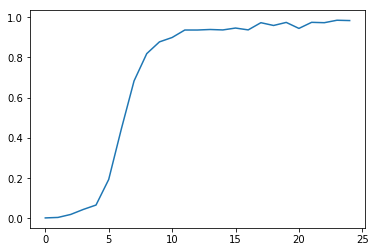

In [19]:
(x_train, t_train), (x_text, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

acc_list = learnSeq2seq(x_train, t_train, x_text, t_test, char_to_id, id_to_char, seq2seq_model=PeekySeq2seq)

plt.plot(acc_list)

正解率はなんと98%超え！  
しかし$h$を複数の層に渡すことでパラメータ数が増大し，計算量が増えている．  
また，seq2seqはハイパーパラメータの調整で大きく結果が異なってくるため，他の問題においてはここでやった結果のようになるとは限らない．  
次章からは，seq2seqを劇的に改善させるAttentionというものを取り扱う．

## seq2seqを用いたアプリケーション
seq2seqを使ったアプリケーションを紹介  
例えば
- 機械翻訳
- 自動要約
- 質疑応答
- メールの自動返信

## チャットボット
VPNの接続に関する問題をチャットボットで解決  
このように会話ベースで答えやヒントを得ることができるサービスは実用性が高く，いくつかのWebサイトですでに見ることができる．

## アルゴリズムの学習
自動プログラム作成  
ソースコードも時系列データであり，学習させられる．ifやforも．  
次章ではRNNを拡張したNTM(Neural Turing Machine)について紹介

## イメージキャプション
画像や音声にも適用できる．  
イメージキャプションでは画像を文章へ変換することで画像が何を表しているのかを文字に起こすことができる．  
モデルは上記のseq2seqのEncoderがCNN->Affineになったものなどがある.  
このCNNには，VGGやResNetなどの実績のあるネットワークを用い，重みとしてImageNetなどの学習済みのものを利用するとよい．  
実用には，TensorFlowなどが利用されている．